### Library Import

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("..")

from src.sanity import *

In [2]:
np.random.seed(80)
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

### Load dataset 

In [3]:
from src.load_datasets import load_air_polution_data

dataframe = (
    load_air_polution_data()
    .pipe(format_datetime, col="Date_Time")
    .pipe(set_index, col="Date_Time")
    .pipe(interpolate_column, cols="pollution")
    .pipe(resample_data, freq="H")
)

print(f"dataframe shape {dataframe.shape}")

# dataframe = dataframe.tail(515)

dataframe.head()

dataframe shape (43800, 7)


,pollution,dewp,temp,press,wnd_spd,snow,rain
Date_Time,,,,,,,
2010-01-02 00:00:00,129.0,-16.0,-4.0,1020.0,1.79,0.0,0.0
2010-01-02 01:00:00,148.0,-15.0,-4.0,1020.0,2.68,0.0,0.0
2010-01-02 02:00:00,159.0,-11.0,-5.0,1021.0,3.57,0.0,0.0
2010-01-02 03:00:00,181.0,-7.0,-5.0,1022.0,5.36,1.0,0.0
2010-01-02 04:00:00,138.0,-7.0,-5.0,1022.0,6.25,2.0,0.0


In [4]:
# dataframe.info()
# dataframe.isna().sum()
corr = dataframe.corr()
corr.style.background_gradient(cmap="coolwarm")

,pollution,dewp,temp,press,wnd_spd,snow,rain
pollution,1.000000,0.157731,-0.099956,-0.035189,-0.242691,0.018864,-0.052134
dewp,0.157731,1.000000,0.824432,-0.778737,-0.296720,-0.034484,0.125053
temp,-0.099956,0.824432,1.000000,-0.827205,-0.154902,-0.092726,0.049037
press,-0.035189,-0.778737,-0.827205,1.000000,0.185380,0.069031,-0.079840
wnd_spd,-0.242691,-0.296720,-0.154902,0.185380,1.000000,0.021876,-0.010137
snow,0.018864,-0.034484,-0.092726,0.069031,0.021876,1.000000,-0.009553
rain,-0.052134,0.125053,0.049037,-0.079840,-0.010137,-0.009553,1.000000


### Test Train split

train_xy and test_xy size: (43785, 7), (15, 7)

y_train and x_train size (43785,), (43785, 6)
y_test  and x_test  size (15,),  (15, 6)



(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='pollution'>)

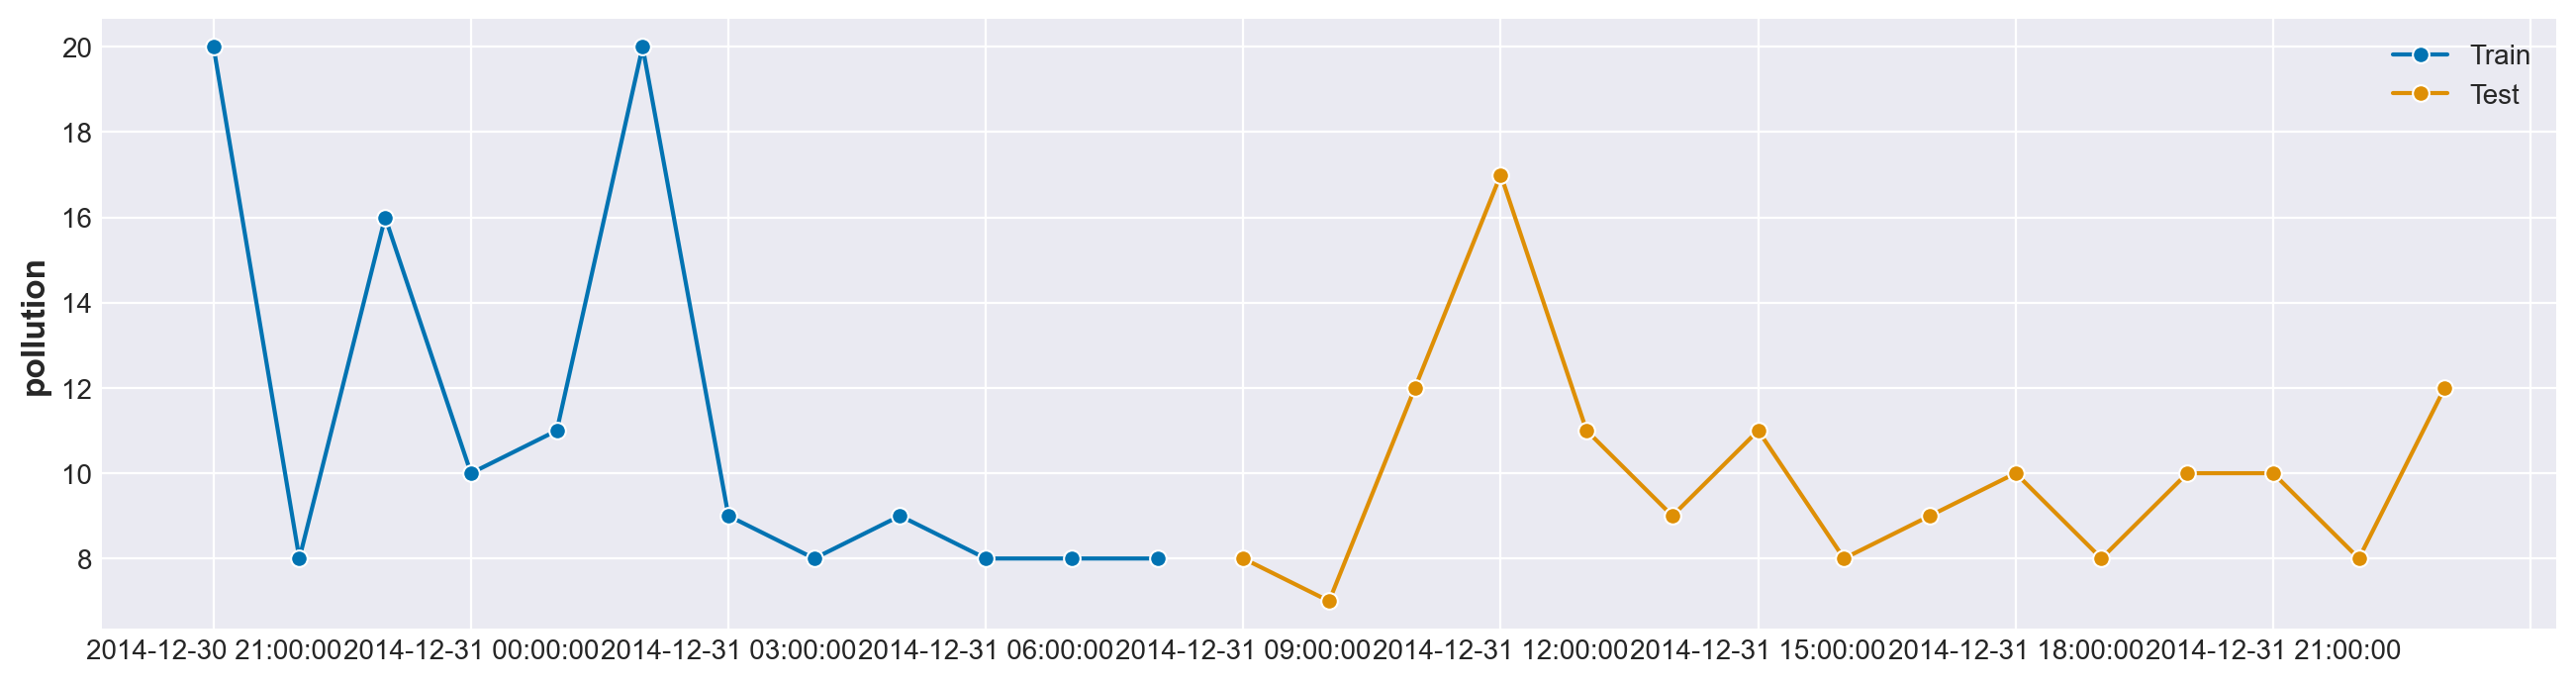

In [5]:
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split

TEST_SIZE = 15
TARGET_COl = "pollution"

train_xy, test_xy = temporal_train_test_split(dataframe, test_size=TEST_SIZE)

print(f"train_xy and test_xy size: {train_xy.shape}, {test_xy.shape}", end="\n\n")

y_train = train_xy[TARGET_COl].copy(deep=True)
x_train = train_xy.drop(columns=[TARGET_COl]).copy(deep=True)

y_test = test_xy[TARGET_COl].copy(deep=True)
x_test = test_xy.drop(columns=[TARGET_COl]).copy(deep=True)

print(f"y_train and x_train size {y_train.shape}, {x_train.shape}")
print(
    f"y_test  and x_test  size {y_test.shape},  {x_test.shape}",
    end="\n\n",
)

plot_series(y_train.tail(12), y_test, labels=["Train", "Test"])

#### Huyper Parameter Selection 

intital_window_size 43710 , step_length 15 for fold 5


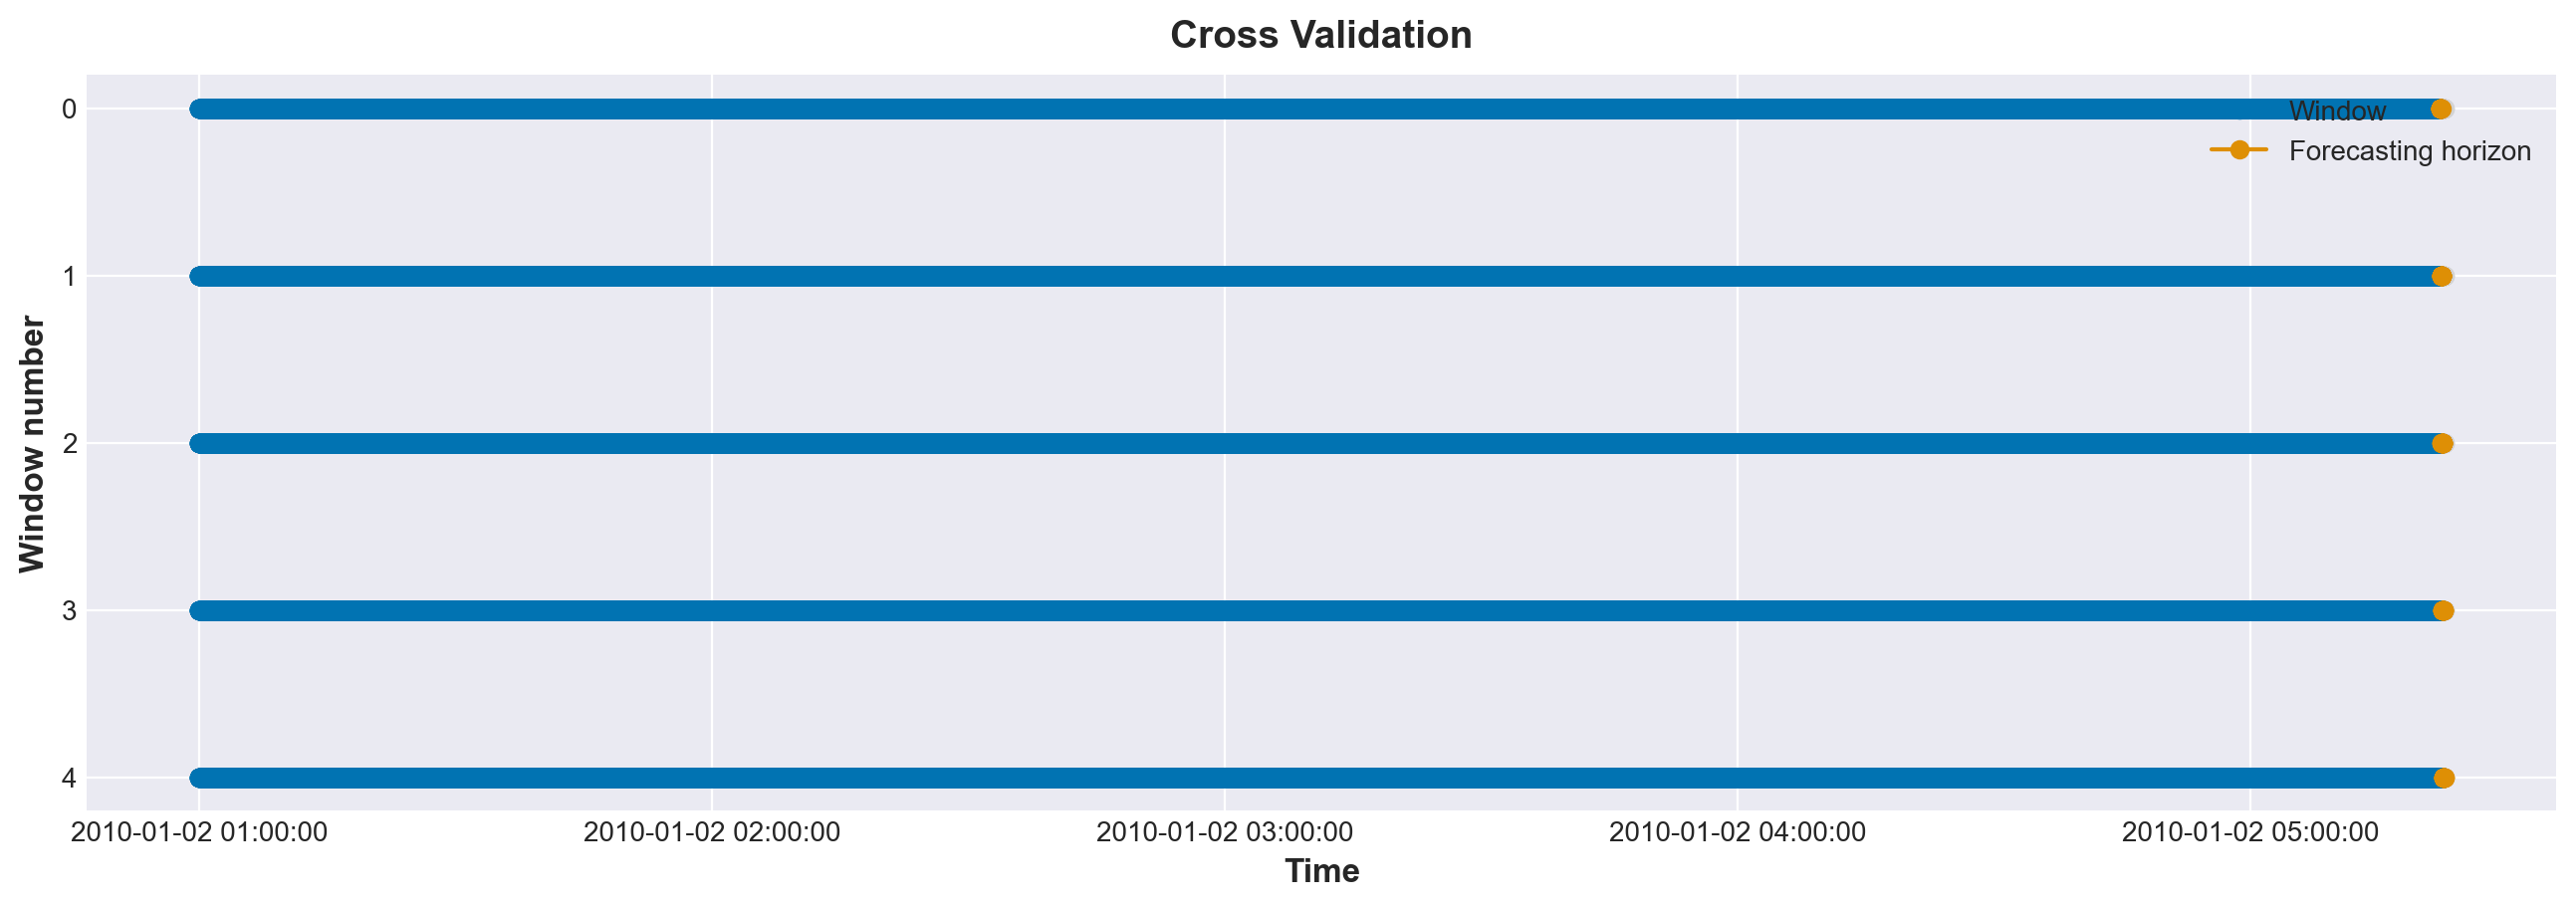

In [6]:
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    SlidingWindowSplitter,
)
from sktime.utils.plotting import plot_windows

fh = np.arange(1, TEST_SIZE + 1)

y_size = len(y_train)

fold = 5

step_length = len(fh)

fh_max_length = max(fh)

intital_window_size = y_size - ((fold - 1) * step_length + 1 * fh_max_length)

# intital_window_size = int(y_train.shape[0] * 0.80)

print(
    f"intital_window_size {intital_window_size} , step_length {step_length} for fold {fold}"
)

cv = ExpandingWindowSplitter(
    fh, initial_window=intital_window_size, step_length=step_length
)

plot_windows(cv, y_train, title="Cross Validation")

In [7]:
from sklearn.preprocessing import MinMaxScaler

try:
    from sklearnex.linear_model import LinearRegression

    print("Importing sklearnex LinearRegression")
except ImportError:
    from sklearn.linear_model import LinearRegression

from sktime.forecasting.compose import (
    ForecastingPipeline,
    make_reduction,
    TransformedTargetForecaster,
)
from sktime.transformations.compose import OptionalPassthrough
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.compose import TransformerPipeline
from sktime.transformations.series.impute import Imputer
from sktime.transformations.series.detrend import (
    Detrender,
    Deseasonalizer,
    ConditionalDeseasonalizer,
)
from sktime.forecasting.trend import PolynomialTrendForecaster

from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

param_grid = {
    "scaler_x__passthrough": [True, False],
    "forecaster__deseasonalizer__model": ["additive"],
    "forecaster__deseasonalizer__sp": [24, 48],
    "forecaster__detrender__forecaster__degree": [1, 2],
    "forecaster__reducer__window_length": [10],
    "forecaster__reducer__estimator__fit_intercept": [True, False],
}

forecaster_pipe = ForecastingPipeline(
    steps=[
        (
            "x_transforner",
            TransformerPipeline(
                steps=[("imputer_x", Imputer(method="ffill", random_state=80))]
            ),
        ),
        (
            "scaler_x",
            OptionalPassthrough(
                TabularToSeriesAdaptor(MinMaxScaler()), passthrough=True
            ),
        ),
        (
            "forecaster",
            TransformedTargetForecaster(
                steps=[
                    ("imputer_y", Imputer(method="ffill", random_state=80)),
                    (
                        "deseasonalizer",
                        ConditionalDeseasonalizer(model="additive", sp=24),
                    ),
                    (
                        "detrender",
                        Detrender(forecaster=PolynomialTrendForecaster(degree=1)),
                    ),
                    (
                        "reducer",
                        make_reduction(
                            estimator=LinearRegression(),
                            scitype="tabular-regressor",
                            window_length=10,
                            strategy="recursive",
                            pooling="global",
                        ),
                    ),
                ]
            ),
        ),
    ]
)

fh = np.arange(1, TEST_SIZE + 1)

cv = ExpandingWindowSplitter(
    fh, initial_window=intital_window_size, step_length=step_length
)

print(f"Number of CPU Count:   {os.cpu_count()}")

n_cpu = os.cpu_count() - 1 if os.cpu_count() > 2 else 1

gscv = ForecastingGridSearchCV(
    forecaster_pipe,
    strategy="refit",
    scoring=MeanAbsolutePercentageError(symmetric=True),
    cv=cv,
    param_grid=param_grid,
    verbose=3,
    n_jobs=-1,
    refit=True,
    error_score="raise",
)

gscv.fit(y_train, X=x_train, fh=fh)

print("Best Params", gscv.best_params_)
print("Best Params", gscv.best_score_)
# print('Best Params', gscv.best_forecaster_)

Number of CPU Count:   12
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Params {'forecaster__deseasonalizer__model': 'additive', 'forecaster__deseasonalizer__sp': 48, 'forecaster__detrender__forecaster__degree': 2, 'forecaster__reducer__estimator__fit_intercept': False, 'forecaster__reducer__window_length': 10, 'scaler_x__passthrough': False}
Best Params 0.7689799102531779


2014-12-31 09:00:00     7.696936
2014-12-31 10:00:00     6.487713
2014-12-31 11:00:00     4.508514
2014-12-31 12:00:00     1.963535
2014-12-31 13:00:00    -1.904687
2014-12-31 14:00:00    -6.410207
2014-12-31 15:00:00    -9.817478
2014-12-31 16:00:00   -10.440708
2014-12-31 17:00:00   -10.469159
2014-12-31 18:00:00    -6.327330
2014-12-31 19:00:00    -1.601683
2014-12-31 20:00:00     4.729972
2014-12-31 21:00:00     8.211187
2014-12-31 22:00:00    10.227800
2014-12-31 23:00:00    10.744825
Freq: H, Name: pollution, dtype: float64

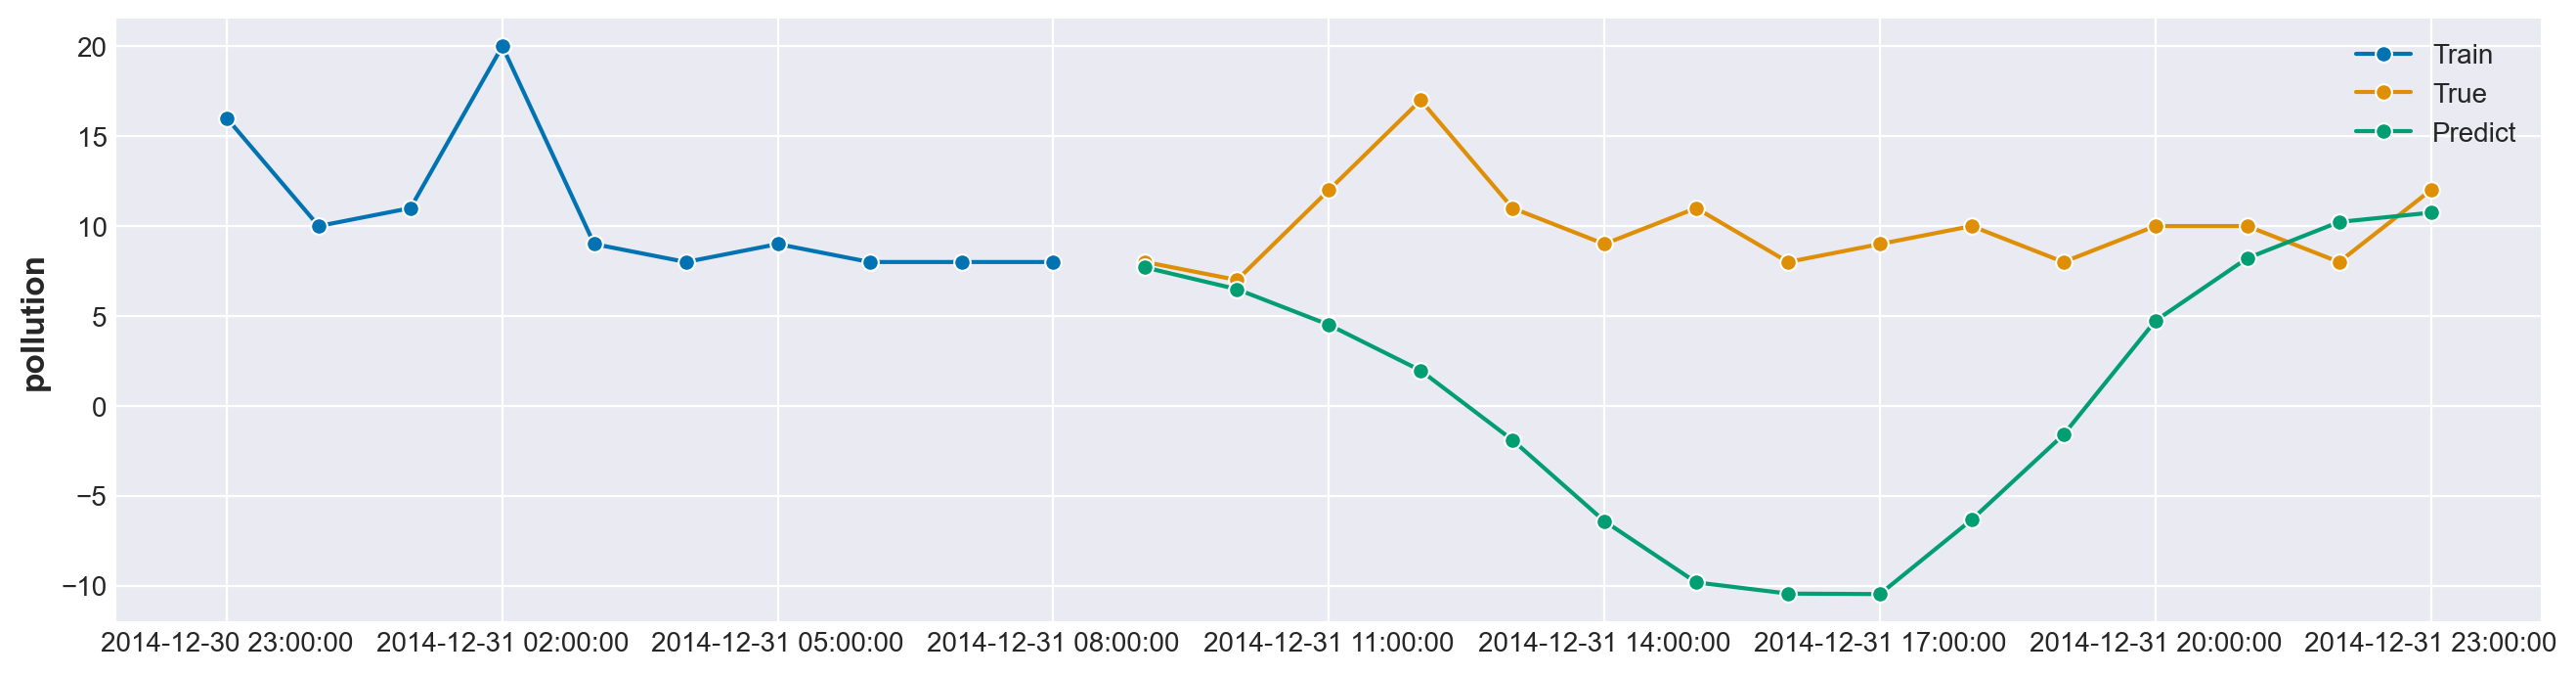

In [8]:
y_predict = gscv.predict(fh=fh, X=x_test)
plot_series(y_train.tail(10), y_test, y_predict, labels=["Train", "True", "Predict"])
y_predict

In [9]:
print(gscv.cv_results_.shape)
gscv.cv_results_.head()

(16, 5)


,mean_test_MeanAbsolutePercentageError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsolutePercentageError
0,0.781997,3.311792,3.184516,{'forecaster__deseasonalizer__model': 'additiv...,16.0
1,0.781997,4.769043,2.911122,{'forecaster__deseasonalizer__model': 'additiv...,15.0
2,0.774882,4.922705,3.323433,{'forecaster__deseasonalizer__model': 'additiv...,8.0
3,0.774530,4.247356,3.359646,{'forecaster__deseasonalizer__model': 'additiv...,7.0
4,0.777114,3.838198,3.130821,{'forecaster__deseasonalizer__model': 'additiv...,11.0


### Backtesting Insample Prediction

In [10]:
%%time

from sktime.forecasting.model_evaluation import evaluate

from sktime.performance_metrics.forecasting import (
    MeanSquaredError,
    MeanAbsoluteError,
    MeanAbsolutePercentageError,
    MeanAbsoluteScaledError,
)
from sktime.performance_metrics.forecasting import (mean_absolute_scaled_error, 
                                                    mean_absolute_error,
                                                    )



losses = [
                MeanAbsoluteError(),
                MeanSquaredError(square_root=True),
                MeanAbsolutePercentageError(symmetric=False),
                MeanAbsoluteScaledError(),
            ]

results = evaluate(
    forecaster=gscv.best_forecaster_,
    y=y_train,
    X=x_train,
    cv=cv,
    strategy ='update',
    scoring=losses,
    return_data=False,
    backend='dask'
)
results

CPU times: total: 7.89 s
Wall time: 17.7 s


,test_MeanAbsoluteError,fit_time,pred_time,len_train_window,cutoff,test_MeanSquaredError,test_MeanAbsolutePercentageError,test_MeanAbsoluteScaledError
0,102.572983,11.144588,0.983479,43710,2014-12-28 05:00:00,114.990361,1.947136,8.302446
1,97.312365,0.293633,1.030956,43725,2014-12-28 20:00:00,124.129805,0.315190,7.873178
2,50.162565,0.426747,0.957489,43740,2014-12-29 11:00:00,59.859057,1.321499,4.056292
3,36.741237,0.302659,0.551543,43755,2014-12-30 02:00:00,45.648989,2.351602,2.969689
4,56.470978,0.249315,1.217805,43770,2014-12-30 17:00:00,58.518751,5.139219,4.564570


In [11]:
plot_series(
    y_train.tail(100),
    *results["y_pred"].to_list(),
    labels=["y_pred"] + [f"y_pred_{i}" for i in results.index],
)

KeyError: 'y_pred'

### Get best model Parameters

In [ ]:
gscv.best_forecaster_.get_fitted_params()

### Train Model Parameter

In [ ]:
model_n_features_in = gscv.best_forecaster_.get_fitted_params()[
    "forecaster__reducer__estimator__n_features_in"
]
model_fname_in = gscv.best_forecaster_.get_fitted_params()[
    "forecaster__reducer__estimator__feature_names_in"
]
model_coeff = gscv.best_forecaster_.get_fitted_params()[
    "forecaster__reducer__estimator__coef"
]
model_intercept = gscv.best_forecaster_.get_fitted_params()[
    "forecaster__reducer__estimator__intercept"
]

print(f"model_n_features_in {model_n_features_in}", end="\n\n")
print(f"model_fname_in {model_fname_in}", end="\n\n")
print(f"model_fname_in {model_coeff}", end="\n\n")
print(f"model_fname_in {model_intercept}", end="\n\n")

### model cutoff

In [ ]:
print(gscv.best_forecaster_.cutoff, y_train.index[-1])

### Model saving 

In [12]:
import joblib

joblib.dump(gscv.best_forecaster_, "../results/linear_model.pkl")

['../results/linear_model.pkl']

### Features importance

In [ ]:
pd.DataFrame(model_coeff, index=model_fname_in, columns=["Coeff"]).plot(
    kind="barh", alpha=0.75
)